In [1]:
# Recap Previously on this series we have started with VQC_Graph_encoding, built a cirq circuit and compared the input features with injected anamolies for Cirq learning.
# in file two vqc_classifier_training, we've defined a simple ansatz the variational block we use is a simple ansatz — a parameterized quantum circuit template that we’re tuning to minimize classification error
#in file two ansatz = we have included costfunction  trained Brute force parameter optimization (Grid Search) and used trained model on new inputs and realized zero loss, perfect classification

In [2]:
#Define a new circuit with cirq.symbol
import cirq
import numpy as np
import sympy
from collections import Counter

# Define qubits
q0, q1 = cirq.LineQubit.range(2)

# Create symbols for variational parameters
theta_0 = sympy.Symbol('theta_0')
theta_1 = sympy.Symbol('theta_1')

# Reusable circuit builder with symbolic params
def build_symbolic_circuit(features):
    circuit = cirq.Circuit()
    circuit.append([
        cirq.ry(features[0])(q0),
        cirq.ry(features[1])(q1),
        cirq.CNOT(q0, q1),
        cirq.ry(theta_0)(q0),
        cirq.rz(theta_1)(q1),
        cirq.measure(q0, key='label')
    ])
    return circuit

Step 2: Define Loss Function (Cross-Entropy-ish with shift rule)
We'll calculate:

The probability of measuring 1 on q0

Compare it to the true label

Optimize to minimize this difference

In [3]:
simulator = cirq.Simulator()

def run_prob_one(circuit, param_resolver, repetitions=100):
    result = simulator.run(cirq.resolve_parameters(circuit, param_resolver), repetitions=repetitions)
    counts = Counter(result.measurements['label'].flatten())
    p1 = counts[1] / repetitions
    return p1

In [4]:
#Step 3: parameter shift gradient estimate
def parameter_shift_gradient(circuit, features, theta_vals, label, shift=np.pi/2):
    gradients = []
    for i, theta in enumerate([theta_0, theta_1]):
        plus = {theta_0: theta_vals[0], theta_1: theta_vals[1]}
        minus = plus.copy()

        plus[theta] += shift
        minus[theta] -= shift

        # Run both shifted circuits
        circuit_obj = build_symbolic_circuit(features)
        p1_plus = run_prob_one(circuit_obj, plus)
        p1_minus = run_prob_one(circuit_obj, minus)

        # Estimate gradient (∂L/∂θ = (p+ - p-) * (pred - label))
        pred = run_prob_one(circuit_obj, {theta_0: theta_vals[0], theta_1: theta_vals[1]})
        grad = (p1_plus - p1_minus) * 2 * (pred - label)
        gradients.append(grad)
    return gradients


In [5]:
#Step 4: Training Loop
# Initialize parameters
params = np.random.uniform(-np.pi, np.pi, size=2)
learning_rate = 0.5
dataset = [
    (np.pi * np.array([0.25, 0.75]), 0),
    (np.pi * np.array([0.25, 0.25]), 1)
]

for epoch in range(20):
    total_loss = 0
    for features, label in dataset:
        circuit = build_symbolic_circuit(features)
        pred = run_prob_one(circuit, {theta_0: params[0], theta_1: params[1]})
        loss = (pred - label) ** 2
        total_loss += loss

        grads = parameter_shift_gradient(circuit, features, params, label)
        params -= learning_rate * np.array(grads)

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Params = {params}")

Epoch 1: Loss = 0.8528, Params = [2.21000646 2.22493292]
Epoch 2: Loss = 0.8633, Params = [2.00650646 2.16623292]
Epoch 3: Loss = 0.8857, Params = [1.83670646 2.11403292]
Epoch 4: Loss = 0.7730, Params = [1.60870646 2.15403292]
Epoch 5: Loss = 0.9224, Params = [1.51850646 2.21593292]
Epoch 6: Loss = 0.8330, Params = [1.43960646 2.25293292]
Epoch 7: Loss = 0.7853, Params = [1.43350646 2.29103292]
Epoch 8: Loss = 0.8434, Params = [1.35880646 2.33843292]
Epoch 9: Loss = 0.6409, Params = [1.22720646 2.21413292]
Epoch 10: Loss = 0.8069, Params = [1.22980646 2.21613292]
Epoch 11: Loss = 0.6964, Params = [1.21920646 2.30093292]
Epoch 12: Loss = 0.6728, Params = [1.12920646 2.31273292]
Epoch 13: Loss = 0.7321, Params = [1.08860646 2.35973292]
Epoch 14: Loss = 0.8089, Params = [1.20990646 2.36573292]
Epoch 15: Loss = 0.8264, Params = [1.10990646 2.26243292]
Epoch 16: Loss = 0.8452, Params = [1.16130646 2.25323292]
Epoch 17: Loss = 0.6980, Params = [1.05300646 2.20443292]
Epoch 18: Loss = 0.7642

In [6]:
test_input = np.pi * np.array([0.25, 0.25])
test_circuit = build_symbolic_circuit(test_input)
prob_1 = run_prob_one(test_circuit, {theta_0: params[0], theta_1: params[1]})
predicted = 1 if prob_1 > 0.5 else 0
print(f" Final prediction for anomaly: {'Anomaly' if predicted else 'Normal'}")


 Final prediction for anomaly: Anomaly


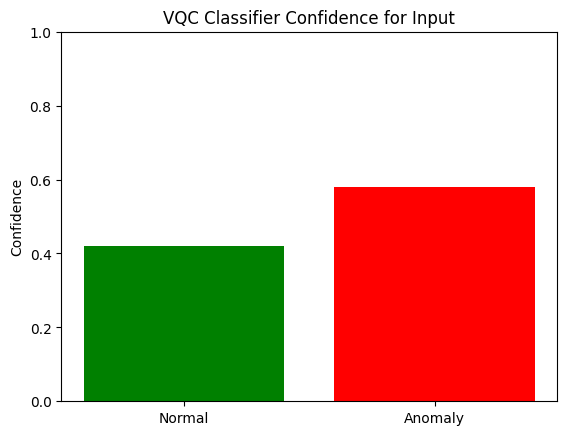

In [7]:
#What does a confidence score look like in your VQC
import matplotlib.pyplot as plt

labels = ['Normal', 'Anomaly']
probs = [1 - prob_1, prob_1]  # 1-prob_1 is for class 0

plt.bar(labels, probs, color=['green', 'red'])
plt.ylabel('Confidence')
plt.title('VQC Classifier Confidence for Input')
plt.ylim([0, 1])
plt.show()

#Scientific Note 
•	"We observed that the gradient-based optimization method (parameter shift rule) was more sensitive to subtle symmetry deviations in anomalous inputs, whereas the brute-force model occasionally misclassified due to a lack of fine-grained loss resolution. This suggests the value of smooth loss navigation in quantum classifiers even with low-repetition sampling."
